In [1]:
from plotnine import *
import pandas as pd
import numpy as np
import warnings
import os
import gc

pd.set_option('display.max_columns', 1_00)
warnings.filterwarnings('ignore')

In [2]:
RAW_DATA_PATH_ADMISSION = '../raw_data/IDs_mapping.csv'
RAW_DATA_PATH_DIABETES  = '../raw_data/diabetic_data.csv'
DATA_PATH = '../data'
DATA_PATH_MAP = DATA_PATH + '/map_id'

# 1. IMPORT

In [3]:
df_map = pd.read_csv(RAW_DATA_PATH_ADMISSION)
df = pd.read_csv(RAW_DATA_PATH_DIABETES)

# 2. TIDY

### 2.1. Add descriptions to main dataframe `df` and remove ids

In [4]:
# admission types
df_admission = df_map[:8]
df_discharge = df_map[10:40].rename(columns = {'admission_type_id':'discharge_disposition_id'})
df_admission_source = df_map[42:66].rename(columns = {'admission_type_id': 'admission_source_id'})
df_admission.iloc[:,0] = df_admission.iloc[:,0].astype(int)
df_discharge.iloc[:,0] = df_discharge.iloc[:,0].astype(int)
df_admission_source.iloc[:,0] = df_admission_source.iloc[:,0].astype(int)
df_admission.rename(columns = {'description': 'admission_type'},inplace=True)
df_discharge.rename(columns = {'description': 'discharge_disposition'},inplace=True)
df_admission_source.rename(columns = {'description': 'admission_source'},inplace=True)

# clean columns in df
df.columns = list(map(lambda i: i.lower().replace('-','_'), df.columns))

# merge with maps ids
df = df.merge(df_admission, on = 'admission_type_id', how='left')
df = df.merge(df_discharge, on = 'discharge_disposition_id', how='left')
df = df.merge(df_admission_source, on = 'admission_source_id', how='left')

# remove description columns
df.drop(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

# drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

# save
df.to_csv(os.path.join(DATA_PATH, 'diabetes_tidy.csv'), index=False)

# free memory
del df_discharge, df_admission, df_admission_source
gc.collect()

0

### 2.2 Create a dataset in DATA_PATH_MAP with all map dataframe to map description and ids

In [5]:
def df_id_map(df, column):
    aux = pd.DataFrame(df[column].value_counts().index, columns=[column])
    aux[f'{column}_id'] = list(range(1,len(aux)+1))
    return aux

def create_maps(df, columns, data_path):
    map_dict = {i:df_id_map(df,i) for i in columns}
    # save map dict
    for k, v in map_dict.items():
        v.to_csv(os.path.join(data_path, f'{k}.csv'), index=False)

In [6]:
create_maps(df, list(df.select_dtypes('object').columns), DATA_PATH_MAP)

### 2.3. Apply the mapping system created to the main dataframe `df`

In [7]:
def apply_map_id(df, data_path):
    data_maps = list(map(lambda i: os.path.join(data_path,i),os.listdir(data_path)))
    for i in data_maps:
        aux = pd.read_csv(i)
        id_col = list(filter(lambda i:i.endswith('_id'), aux.columns))[0]
        on_col = list(set(aux.columns).difference(set([id_col])))[0]
        aux[id_col] = aux[id_col].astype(int)
        df = df.merge(aux,on=on_col, how='left')
        df.drop(on_col, axis=1, inplace = True)
        df[id_col] = df[id_col].fillna(0)
        df[id_col] = df[id_col].astype(int)
    return df

In [8]:
df_tidy = apply_map_id(df, DATA_PATH_MAP)

In [9]:
df_tidy.dtypes

encounter_id                   int64
patient_nbr                    int64
time_in_hospital               int64
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
number_diagnoses               int64
rosiglitazone_id               int64
acetohexamide_id               int64
a1cresult_id                   int64
citoglipton_id                 int64
age_id                         int64
gender_id                      int64
glipizide_metformin_id         int64
miglitol_id                    int64
metformin_id                   int64
tolbutamide_id                 int64
nateglinide_id                 int64
acarbose_id                    int64
admission_type_id              int64
pioglitazone_id                int64
weight_id                      int64
readmitted_id                  int64
troglitazone_id                int64
g

In [10]:
# save it
df_tidy.to_csv(os.path.join(DATA_PATH, 'diabetes_integers.csv'), index=False)

# 3. Explore

### 3.1 Remove some columns with high missing values [`weight`, `payer_code`, `medical_specialty`]

In [11]:
missing_values = {i : (df[i] == '?').mean() for i  in df.columns}
missing_values = {k:v for k,v in missing_values.items() if v>0}
pd.DataFrame.from_dict([missing_values]).melt()

,variable,value
0,race,0.022336
1,weight,0.968585
2,payer_code,0.395574
3,medical_specialty,0.490822
4,diag_1,0.000206
5,diag_2,0.003518
6,diag_3,0.013983


In [12]:
df_tidy.drop(['weight_id', 'payer_code_id', 'medical_specialty_id'],axis=1,inplace=True)

### 3.2 Categorical values
As we can see in the next picture, the univariant effeect of categorical variables has no impact to clasiffy an observation as readmitted or not. The frequentist analysis of those categories shows that the percentage of each value of each category are quite close to be 50%

<img src="../img/categorical_univariant_effect.png" width=800 height=800 />


### 3.2 Numerical values
Those density plots are easy to explain. the variables have negative imapact, I mean, the more the worse, the more medication yo need, the more prob. to be readmitted, the more time in hostpital, the more prob. to be readmitted. 
So when the X increase the density graph green (be readmitted) is higher than de density of red (not). 
But as we can see those numerical variables has not much power to classify

<img src="../img/density_numerics.png" width=800 height=800 />


### 3.2 High cardinality categories
When categorical variables have many categories, we call them high cardinality categorical variables. It is usually difficult to work with them, a trick is to find that category that hides more information, that is, that has more predictive capacity. For this we can use the standard deviation in the frequency of appearance in readmitted (1) or not (0) and we see that there are certain categories with a lot of classification capacity. Good news. 


<img src="../img/high_categorical.png" width=800 height=800 />


# 4. Transform

I have created two sklearn transfomer classes , 
* one that allows the calculation of the weigth of evidence `WeighOfEvidence` , 
* another that acts as a wrapper between the different weight of evidence and RobustScaler `Transformer`

In [13]:
from sklearn.preprocessing import RobustScaler

class WeighOfEvidence:
    
    def __init__(self, categorical_colums, function = 'mean', preffix = 'woe'):
        cc = categorical_colums
        self.categorical_colums = cc if isinstance(cc, list) else [cc]
        self.function = function
        self.preffix = str(preffix)
        
    
    @staticmethod
    def mapper(df, by, category_col, value_col):
        categories = df[by].unique()
        return {j:{i.value:i.n for i in df.loc[df[by]==j,[category_col,value_col]].itertuples()} for j in categories}

    def weight_of_evidence_fit(self, df, by, categorical_colums, function='mean'):
        df  =pd.concat([X,pd.DataFrame(y.values, columns=['by'])],axis=1)
        df_long = df[categorical_colums + ['by']].melt('by')
        woe =  df_long.groupby(['variable','value']).agg(n=('by' ,function)).reset_index()
        return self.mapper(woe, 'variable', 'value', 'n')
    
    @staticmethod
    def weight_of_evidence_transform(df, weight_of_evidence_fitted, preffix='woe'):
        for k,v in weight_of_evidence_fitted.items():
            df[f'{preffix}_{k}'] = df[k].map(v)
            df[f'{preffix}_{k}'] = df[f'{preffix}_{k}'].fillna(0)
        return df
    
        
    def fit(self, X=None, y=None):
        self.weight_of_evidence = self.weight_of_evidence_fit(X, 
                                                              y ,
                                                              self.categorical_colums, 
                                                              self.function)
        self.columns = list(map(lambda i:f'{self.preffix}_{i}',self.weight_of_evidence.keys()))
        return self
    
    def transform(self, X):
        return self.weight_of_evidence_transform(X, self.weight_of_evidence, self.preffix)
    
    
    def fit_transform(self, X=None, y=None):
        return self.fit(X, y).transform(X)
    
    
class Transformer:
    def __init__(self, 
                 numeric_columns, 
                 woe_colums, 
                 woe_by , 
                 scaler = RobustScaler(),
                 woe_function = 'mean', 
                 woe_preffix = 'woe'):
        self.weigh_of_evidence = WeighOfEvidence(woe_colums, woe_function, woe_preffix)
        self.scaler = scaler
        self.scale_columns = numeric_columns

        
    def fit(self, X, y=None):
        self.weigh_of_evidence.fit(X, y)
        if self.scaler != None:
            self.scale_columns += self.weigh_of_evidence.columns
            df = self.weigh_of_evidence.transform(X)
            self.scaler.fit(df[self.scale_columns])
        return self
        

    def transform(self, X):
        df =  self.weigh_of_evidence.transform(X)
        if self.scaler != None:
            matrix = self.scaler.transform(df[self.scale_columns])
            df = pd.DataFrame(matrix, columns=self.scale_columns)
        return df[list(np.unique(df.columns))]
    
    def fit_transform(self, X=None, y=None):
        return self.fit(X, y).transform(X)
            

### 4.1 Split of X and y using numerical features & categorical features and the creation of a binary label `readmitted_binary` that will be 1 if `readmitted` is <30 or >=30 and 0 if `readmitted` is NO

In [14]:
numerical_features   = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                        'number_outpatient', 'number_emergency', 'number_diagnoses']
indexes_columns      = ['encounter_id', 'patient_nbr']
label_column         = ['readmitted_id']
label_binary_column  = ['readmitted_binary']
non_categorical_cols = numerical_features + indexes_columns + label_column + label_binary_column
categorical_features = [i for i in df_tidy.columns if i not in non_categorical_cols]

In [15]:
df_tidy['readmitted_binary'] = np.where(df_tidy['readmitted_id']==1,0,1)

In [16]:
X = df_tidy[categorical_features+numerical_features]
y = df_tidy[label_binary_column]

# 5 Model

## 5.1 Create the pipeline using the previous transformer

In [17]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

In [18]:
def plot_cv(cv_score):
    df_cv_score = pd.DataFrame(cv_score).drop(['fit_time', 'score_time'],axis=1).reset_index().melt('index')
    df_cv_score['test'] = df_cv_score['variable'].map(lambda i: 1 if 'test_' in i else 0)
    df_cv_score['metric'] = df_cv_score['variable'].replace('test_|train_','',regex=True)
    df_cv_score.drop('variable',axis=1,inplace=True)
    return ggplot(df_cv_score,aes(x='index', y='value', fill='factor(test)')) +\
                geom_col(position='dodge') + facet_wrap('metric',scales='free') +\
                coord_flip(), df_cv_score

In [19]:
scoring_dict = {'accuracy': make_scorer(accuracy_score), 
                'f1_micro':make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average='micro')), 
                'precision': make_scorer(lambda y_true, y_pred: precision_score(y_true, y_pred, average='micro')),
                'recall': make_scorer(lambda y_true, y_pred: recall_score(y_true, y_pred, average='micro'))}

In [20]:
transformer = Transformer(numerical_features,
                          categorical_features,
                          label_binary_column)
model = LGBMClassifier(boosting_type='dart',
                       objective = 'binary',
                       n_estimators=100,
                       reg_alpha = 2, 
                       reg_lambda = 2)

In [21]:
pipeline = make_pipeline(transformer, model)

## 5.2 Cross validation

In [22]:
%%time
cv_score = cross_validate(pipeline, X, y ,cv=5,scoring=scoring_dict,return_train_score=True) 

CPU times: user 1min 22s, sys: 1.98 s, total: 1min 24s
Wall time: 10.9 s


In [23]:
plot, df_cv = plot_cv(cv_score)

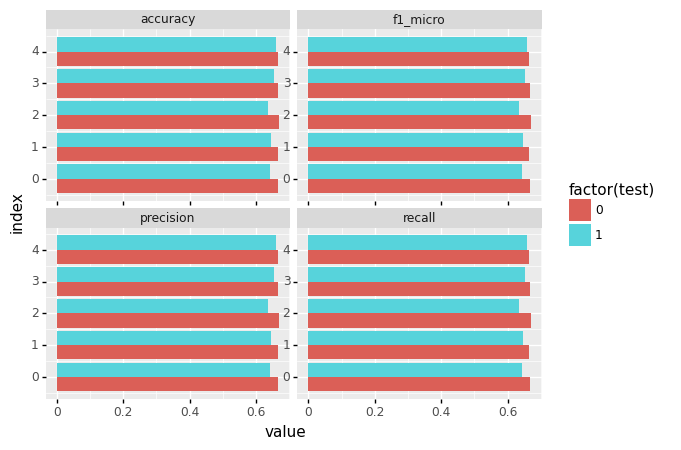

<ggplot: (376360244)>

In [24]:
plot

In [25]:
df_cv.groupby(['metric']).agg(n=('value','mean')).reset_index()

,metric,n
0,accuracy,0.657004
1,f1_micro,0.657004
2,precision,0.657004
3,recall,0.657004


## 5.3 ROC Curve and evaluation

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42)

In [28]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

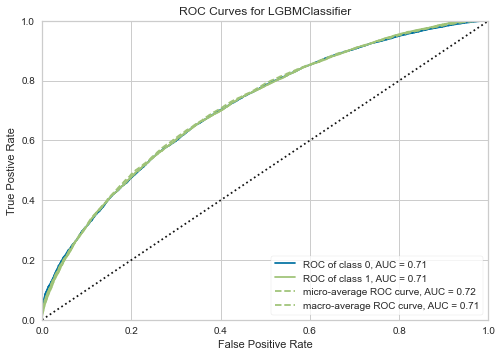

<AxesSubplot:title={'center':'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [29]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(pipeline, classes=[0,1])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()       

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69     14769
           1       0.58      0.64      0.61     10673

    accuracy                           0.66     25442
   macro avg       0.65      0.65      0.65     25442
weighted avg       0.66      0.66      0.66     25442



## Accuracy of 66% and AUC 71%. Not a good model but a great benchmark to beat